!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

In [1]:
import os
from pathlib import Path
data_dir = "pubmed-rct\PubMed_20k_RCT_numbers_replaced_with_at_sign"
os.listdir(data_dir)

['dev.txt', 'test.txt', 'train.txt']

In [2]:
filenames = [data_dir + "\\" + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct\\PubMed_20k_RCT_numbers_replaced_with_at_sign\\dev.txt',
 'pubmed-rct\\PubMed_20k_RCT_numbers_replaced_with_at_sign\\test.txt',
 'pubmed-rct\\PubMed_20k_RCT_numbers_replaced_with_at_sign\\train.txt']

In [3]:
def preprocessor(data_address):
    with open (data_address) as f:
        text = f.readlines()
    preprocessed_data = []
    segment = []  # Temporary storage for the current segment
    total_lines = 0  # Total lines in the current segment

    for line in text:
        if line.startswith("###"):  # Ignore metadata lines
            continue
        elif line.startswith("\n"):  # End of a segment
            # Add total line count to all lines in the segment
            for entry in segment:
                entry["total_lines"] = total_lines
                preprocessed_data.append(entry)
            # Reset for the next segment
            segment = []
            total_lines = 0
            continue
        else:
            total_lines += 1
            line_parts = line.split("\t")
            segment.append({
                "line_number": total_lines,
                "target": line_parts[0],
                "text": line_parts[1],
            })
    return preprocessed_data

In [4]:
import pandas as pd
val_df = pd.DataFrame(preprocessor('pubmed-rct\\PubMed_20k_RCT\\dev.txt'))
train_df = pd.DataFrame(preprocessor('pubmed-rct\\PubMed_20k_RCT\\train.txt'))
test_df = pd.DataFrame(preprocessor('pubmed-rct\\PubMed_20k_RCT\\test.txt'))

In [6]:
val_df.head()

,line_number,target,text,total_lines
0,1,BACKGROUND,IgE sensitization to Aspergillus fumigatus and...,10
1,2,BACKGROUND,It is not clear whether these patients would b...,10
2,3,OBJECTIVE,We sought to determine whether a 3-month cours...,10
3,4,METHODS,Asthmatic patients who were IgE sensitized to ...,10
4,5,METHODS,Primary outcomes were improvement in quality o...,10


In [7]:
train_df.head(5)

,line_number,target,text,total_lines
0,1,OBJECTIVE,To investigate the efficacy of 6 weeks of dail...,12
1,2,METHODS,A total of 125 patients with primary knee OA w...,12
2,3,METHODS,Outcome measures included pain reduction and i...,12
3,4,METHODS,Pain was assessed using the visual analog pain...,12
4,5,METHODS,Secondary outcome measures included the Wester...,12


In [8]:
test_df.head(10)

,line_number,target,text,total_lines
0,1,BACKGROUND,This study analyzed liver function abnormaliti...,9
1,2,RESULTS,A post hoc analysis was conducted with the use...,9
2,3,RESULTS,Liver function tests ( LFTs ) were measured at...,9
3,4,RESULTS,Survival analyses were used to assess the asso...,9
4,5,RESULTS,The percentage of patients with abnormal LFTs ...,9
5,6,RESULTS,When mean hemodynamic profiles were compared i...,9
6,7,RESULTS,Multivariable analyses revealed that patients ...,9
7,8,CONCLUSIONS,Abnormal LFTs are common in the ADHF populatio...,9
8,9,CONCLUSIONS,Elevated MELD-XI scores are associated with po...,9
9,1,BACKGROUND,Minimally invasive endovascular aneurysm repai...,13


<Axes: ylabel='target'>

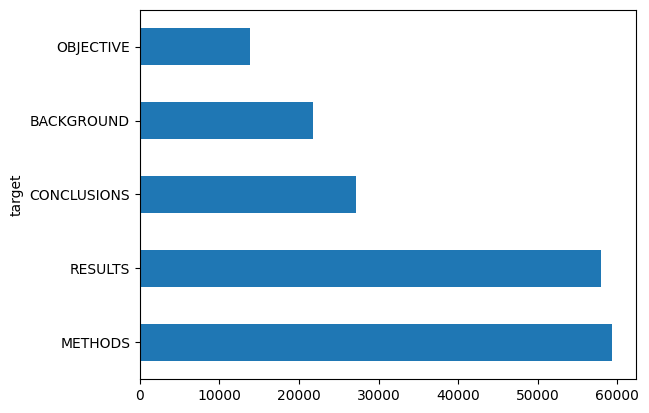

In [9]:
import matplotlib.pyplot as plt
train_df.target.value_counts().plot(kind='barh')

In [5]:
train_sentences = train_df.text.tolist()
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()

In [11]:
val_sentences[:10]

['IgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
 'It is not clear whether these patients would benefit from antifungal treatment .\n',
 'We sought to determine whether a 3-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
 'Asthmatic patients who were IgE sensitized to A fumigatus with a history of at least 2 severe exacerbations in the previous 12 months were treated for 3 months with 200 mg of voriconazole twice daily , followed by observation for 9 months , in a double-blind , placebo-controlled , randomized design .\n',
 'Primary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the 12 months of the study .\n',
 'Sixty-five patients were randomized .\n',
 'Fifty-nine patients started treatment ( 32 receiving voriconazole and

In [6]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df.target.values.reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df.target.values.reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df.target.values.reshape(-1, 1))
print(train_labels_one_hot.shape)
print(val_labels_one_hot.shape)
print(test_labels_one_hot.shape)

(180040, 5)
(30212, 5)
(30135, 5)


In [7]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df.target.values)
val_labels = label_encoder.transform(val_df.target.values)
test_labels = label_encoder.transform(test_df.target.values)
print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(180040,)
(30212,)
(30135,)


In [13]:
# Baseline Model i.e Naive bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

baseline = Pipeline([
    ('tfidf',TfidfVectorizer()),
                    ('clf',MultinomialNB())
                    ])

baseline.fit(train_sentences,train_labels)
y_pred = baseline.predict(val_sentences)

In [14]:
from helper_functions import calculate_metrics
baseline_results = calculate_metrics(val_labels,y_pred)
baseline_results

{'accuracy': 0.7317291142592347,
 'precision': 0.7315166696974572,
 'recall': 0.7317291142592347,
 'f1': 0.7058060715307974}

In [14]:
import numpy as np
sent_len = [len(sentence.split()) for sentence in train_sentences]
average_sent_len = np.mean(sent_len)
average_sent_len

26.338435903132638

In [15]:
output_seq_len = int(np.percentile(sent_len,95))
output_seq_len

55

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization,Embedding

max_tokens = 680000  # Maximum vocab size.
max_len = output_seq_len # Sequence length to pad the outputs to.
# Create the layer.
vectorize_layer = TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=output_seq_len)
vectorize_layer.adapt(train_sentences)

In [26]:
rct_vocab_20K = vectorize_layer.get_vocabulary()
rct_vocab_20K[:6]

['', '[UNK]', 'the', 'and', 'of', 'in']

In [27]:
embedding_layer = Embedding(
    input_dim=len(rct_vocab_20K),
    output_dim=128,
    mask_zero=True,
    name="token_embedding"
    )

In [21]:
# creating data set for better peformance and reduced time
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [22]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [44]:
# Use conv1d model
input = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
x = vectorize_layer(input)
x = embedding_layer(x)
x = tf.keras.layers.Conv1D(128, 5, activation='relu',padding='same')(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
output = tf.keras.layers.Dense(5, activation='softmax')(x)
model_1 = tf.keras.Model(input, output)
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          11411456  
                                                                 
 conv1d (Conv1D)             (None, 55, 128)           82048     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 645   

In [45]:
model_1.compile(
    loss='categorical_crossentropy',
    optimizer= tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [46]:
from keras import backend as K 

# Do some code, e.g. train and save model

K.clear_session()

In [47]:
from helper_functions import create_tensorboard_callback
import datetime
import tensorflow as tf
from keras import backend as K

# Use it during model training
history_1 = model_1.fit(
    train_dataset,
    steps_per_epoch=int(0.1 * len(train_dataset)),
    epochs=5,
    validation_data=valid_dataset,  # Removed parentheses; valid_dataset is a dataset, not a tuple
    validation_steps=int(0.1 * len(valid_dataset)),                
   
)

K.clear_session()


Epoch 1/5
562/562 [==============================] - 42s 73ms/step - loss: 0.3370 - accuracy: 0.9079 - val_loss: 0.7562 - val_accuracy: 0.7623
Epoch 2/5
562/562 [==============================] - 43s 76ms/step - loss: 0.4776 - accuracy: 0.8335 - val_loss: 0.6387 - val_accuracy: 0.7726
Epoch 3/5
562/562 [==============================] - 42s 75ms/step - loss: 0.4670 - accuracy: 0.8375 - val_loss: 0.6094 - val_accuracy: 0.7806
Epoch 4/5
562/562 [==============================] - 41s 73ms/step - loss: 0.5895 - accuracy: 0.7888 - val_loss: 0.5773 - val_accuracy: 0.7932
Epoch 5/5
562/562 [==============================] - 41s 73ms/step - loss: 0.5765 - accuracy: 0.7921 - val_loss: 0.5497 - val_accuracy: 0.8022


In [49]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 9s 9ms/step - loss: 0.5431 - accuracy: 0.8058


[0.5431056618690491, 0.8058056235313416]

In [50]:
model_probs = model_1.predict(valid_dataset)
model_preds = model_probs.argmax(axis = 1)

from helper_functions import calculate_metrics
model_1_results = calculate_metrics(val_labels,model_preds)
model_1_results

945/945 [==============================] - 5s 5ms/step


{'accuracy': 0.8058056401429895,
 'precision': 0.8061259044579924,
 'recall': 0.8058056401429895,
 'f1': 0.8026146566042901}

In [57]:
# save model

model_1.save_weights('model_1//model_1',save_format='tf')

In [17]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_text

# Define the preprocessor and encoder layers
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3", 
    name="text_preprocessor"
)
encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/cmlm-en-base/1", 
    name="USE_encoder",
    output_key="pooled_output"  # Explicitly choose pooled output (sequence-level embedding)
)

# Define the input layer
input_layer = layers.Input(shape=(), dtype=tf.string, name="text_input")

# Build the model pipeline
x = preprocessor(input_layer)
encoder_output = encoder(x)  # Extract the relevant output from the encoder
x = layers.Dense(64, activation='relu', name="dense_64")(encoder_output)
output_layer = layers.Dense(5, activation='softmax', name="output_layer")(x)

model_2 = tf.keras.Model(inputs=input_layer, outputs=output_layer, name="model_2_USE")

# Compile the model
model_2.compile(
    loss='categorical_crossentropy',
    optimizer= tf.keras.optimizers.Adam(),
    metrics=['accuracy']

)

# Summary of the model
model_2.summary()


Model: "model_2_USE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 text_preprocessor (KerasLayer)  {'input_mask': (Non  0          ['text_input[0][0]']             
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                            

In [18]:
from helper_functions import create_tensorboard_callback
import datetime
import tensorflow as tf
from keras import backend as K

# Use it during model training
history_2 = model_2.fit(
    train_dataset,
    steps_per_epoch=int(0.1 * len(train_dataset)),
    epochs=5,
    validation_data=valid_dataset,  # Removed parentheses; valid_dataset is a dataset, not a tuple
    validation_steps=int(0.1 * len(valid_dataset)),                
   
)

K.clear_session()

Epoch 1/5
562/562 [==============================] - 2117s 4s/step - loss: 0.7545 - accuracy: 0.7246 - val_loss: 0.5829 - val_accuracy: 0.7832
Epoch 2/5
562/562 [==============================] - 2112s 4s/step - loss: 0.5540 - accuracy: 0.7975 - val_loss: 0.5508 - val_accuracy: 0.8009
Epoch 3/5
562/562 [==============================] - 2107s 4s/step - loss: 0.5287 - accuracy: 0.8100 - val_loss: 0.5314 - val_accuracy: 0.8022
Epoch 4/5
562/562 [==============================] - 2101s 4s/step - loss: 0.5092 - accuracy: 0.8158 - val_loss: 0.5132 - val_accuracy: 0.8095
Epoch 5/5
562/562 [==============================] - 2099s 4s/step - loss: 0.5123 - accuracy: 0.8171 - val_loss: 0.4950 - val_accuracy: 0.8208


In [19]:
model_2_probs = model_2.predict(valid_dataset)
model_2_preds = model_2_probs.argmax(axis = 1)

from helper_functions import calculate_metrics
model_2_results = calculate_metrics(val_labels,model_2_preds)
model_2_results

945/945 [==============================] - 8029s 9s/step


{'accuracy': 0.8244075201906528,
 'precision': 0.8245695751275294,
 'recall': 0.8244075201906528,
 'f1': 0.8222582753927986}

# character level encoding

In [10]:
train_sentences[:10]

['To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .\n',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'Pain was assessed using the visual analog pain scale ( 0-100 mm ) .\n',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .\n',
 'Serum levels of interleukin 1 ( IL-1 ) , IL-6 , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .\n',

In [31]:
def split_chars(text):
    return ' '.join(list(text))

In [32]:
train_chars = [split_chars(text) for text in train_sentences]
val_chars = [split_chars(text) for text in val_sentences]
test_chars = [split_chars(text) for text in test_sentences]

In [33]:
train_chars[:10]

['T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   6   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   1 2   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   . \n',
 'A   t o t a l   o f   1 2 5   p a t i e n t s   w i t h   p r i m a r y   k n e e   O A   w e r e   r a n d o m i z e d   1 : 1   ;   6 3   r e c e i v e d   7 . 5   m g / d a y   o f   p r e d n i s o l o n e   a n d   6 2   r e c e i v e d   p l a c e b o   f o r   6   w e e k s   . \n',
 'O u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o 

In [49]:
import numpy as np
sent_len = [len(text.split()) for text in train_chars]
avg_len = np.mean(sent_len)
avg_len

126.66784047989336

In [50]:
output_seq_len = int(np.percentile(sent_len, 95))
output_seq_len

245

In [51]:
from tensorflow.keras.layers import TextVectorization,Embedding

max_tokens = 680000  # Maximum vocab size.
max_len = output_seq_len # Sequence length to pad the outputs to.
# Create the layer.
vectorize_layer = TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=output_seq_len)
vectorize_layer.adapt(train_chars)

In [52]:
rct_vocab_20K_chars = vectorize_layer.get_vocabulary()
rct_vocab_20K_chars[:6]

['', '[UNK]', 'e', 't', 'i', 'a']

In [61]:
len(rct_vocab_20K_chars)

38

In [54]:
embed_layer = Embedding(
    input_dim=len(rct_vocab_20K_chars),
    output_dim=128,
    mask_zero=True,
    name="token_embedding"
)

In [56]:
#now model 3 in functionalkn api
import tensorflow as tf
input = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
x = vectorize_layer(input)
x = embed_layer(x)
x = tf.keras.layers.Conv1D(128, 5, activation='relu',padding='same')(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
output = tf.keras.layers.Dense(5, activation='softmax')(x)
model_3 = tf.keras.Model(input, output)
model_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 245)              0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 245, 128)         4864      
                                                                 
 conv1d (Conv1D)             (None, 245, 128)          82048     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 645   

In [57]:
# create scheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)
model_3.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [59]:
train_dataset_chars = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot))
train_dataset_chars = train_dataset_chars.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset_chars = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot))
valid_dataset_chars = valid_dataset_chars.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_chars = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot))
test_dataset_chars = test_dataset_chars.batch(32).prefetch(tf.data.AUTOTUNE)

In [60]:
history_3 = model_3.fit(
    train_dataset_chars,
    steps_per_epoch=int(0.1 * len(train_dataset_chars)),
    epochs=5,
    validation_data=valid_dataset_chars,  # Removed parentheses; valid_dataset is a dataset, not a tuple
    validation_steps=int(0.1 * len(valid_dataset_chars)),
)

Epoch 1/5
562/562 [==============================] - 32s 43ms/step - loss: 1.2034 - accuracy: 0.5084 - val_loss: 1.0511 - val_accuracy: 0.5572
Epoch 2/5
562/562 [==============================] - 23s 41ms/step - loss: 1.0084 - accuracy: 0.5914 - val_loss: 0.9087 - val_accuracy: 0.6466
Epoch 3/5
562/562 [==============================] - 26s 45ms/step - loss: 0.9018 - accuracy: 0.6498 - val_loss: 0.8430 - val_accuracy: 0.6755
Epoch 4/5
562/562 [==============================] - 28s 49ms/step - loss: 0.8375 - accuracy: 0.6783 - val_loss: 0.7825 - val_accuracy: 0.6951
Epoch 5/5
562/562 [==============================] - 24s 42ms/step - loss: 0.7871 - accuracy: 0.7040 - val_loss: 0.7323 - val_accuracy: 0.7197


In [64]:
model_3.evaluate(valid_dataset_chars)

945/945 [==============================] - 18s 19ms/step - loss: 0.7329 - accuracy: 0.7280


[0.7329113483428955, 0.7279557585716248]

In [65]:
model_3_preds = model_3.predict(valid_dataset_chars)
model_3_preds = model_3_preds.argmax(axis = 1)
from helper_functions import calculate_metrics
model_3_results = calculate_metrics(val_labels,model_3_preds)
model_3_results

945/945 [==============================] - 15s 15ms/step


{'accuracy': 0.7279557791605984,
 'precision': 0.7369749327556624,
 'recall': 0.7279557791605984,
 'f1': 0.7285019595443593}